# Load data

In [1]:
# Code sourced from @egorhowell Time Series Video Course

In [2]:
import pandas as pd
import plotly.express as px
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
# Load dataset
data_dir = "drive/MyDrive/Codigo/time series/"
data = pd.read_csv(f"{data_dir}AirPassengers.csv")

In [4]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [6]:
def plotting(title, data, x, y, x_label, y_label):
  """General function to plot data."""
  fig = px.line(data, x=data[x], y=data[y], labels={x: x_label, y: y_label})

  fig.update_layout(template="simple_white", font=dict(size=18),
                    title_text=title, width=650,
                    title_x=0.5, height=400)

  fig.show()

In [7]:
# Plot data
plotting(title='Airline Passengers', data=data, x='Month',
         y='#Passengers', x_label='Date', y_label='Passengers')

In [8]:
# Transformations for future analysis
data2 = pd.read_csv(f"{data_dir}AirPassengers.csv", index_col=0)
data2.index = pd.to_datetime(data2.index)

In [9]:
data3 = pd.read_csv(f"{data_dir}AirPassengers.csv")
data3['Month'] = pd.to_datetime(data3['Month'])

# Basic analysis

## Remove seasonality

In [10]:
data["Passenger_Season_Diff"] = data["#Passengers"].diff(periods=12)

plotting(title='Airline Passengers', data=data, x='Month', y='Passenger_Season_Diff',
         x_label='Date', y_label='Passengers<br>Difference Transform')

In [11]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    """Using an ADF test to determine if a series is stationary"""
    test_results = adfuller(series)
    print('ADF Statistic: ', test_results[0])
    print('P-Value: ', test_results[1])
    print('Critical Values:')
    for thres, adf_stat in test_results[4].items():
        print('\t%s: %.2f' % (thres, adf_stat))


adf_test(data["Passenger_Season_Diff"][12:])

ADF Statistic:  -3.383020726492481
P-Value:  0.011551493085514952
Critical Values:
	1%: -3.48
	5%: -2.88
	10%: -2.58


## Highlight seasonality and trend

In [12]:
# Remove variance
data["Passenger_Log"] = np.log(data["#Passengers"])

plotting(title='Airline Passengers', data=data, x='Month',
         y='Passenger_Log', x_label='Date', y_label='Passenger<br>Log Transform')

In [13]:
# Apply box-cox transform, more accurate than logarithm
from scipy.stats import boxcox

data['Passengers_box_cox'], lam = boxcox(data['#Passengers'])

plotting(title='Airline Passengers', data=data, x='Month', y='Passengers_box_cox',
         x_label='Date', y_label='Passengers<br>Box-Cox Transform')
print(f"Lambda = {lam}")

Lambda = 0.14802254856840585


## Make data stationary

In [14]:
# Take the difference and log and plot it
data["Passenger_Diff_Log"] = data["Passenger_Log"].diff()

plotting(title='Airline Passengers', data=data, x='Month',
         y='Passenger_Diff_Log', x_label='Date', y_label='Passenger<br>Log and Difference')

In [41]:
# Import packages
from scipy.stats import boxcox

# Make the target stationary
data['Passengers_boxcox'], lam = boxcox(data['#Passengers'])
data["Passenger_stationary"] = data["Passengers_boxcox"].diff()
data.dropna(inplace=True)

plotting(title='Airline Passengers', data=data, x='Month',
         y='Passenger_stationary', x_label='Date', y_label='Passengers Stationary')

We could have made it further stationary by carrying out second order differencing or seasonal differencing

## Decompose series

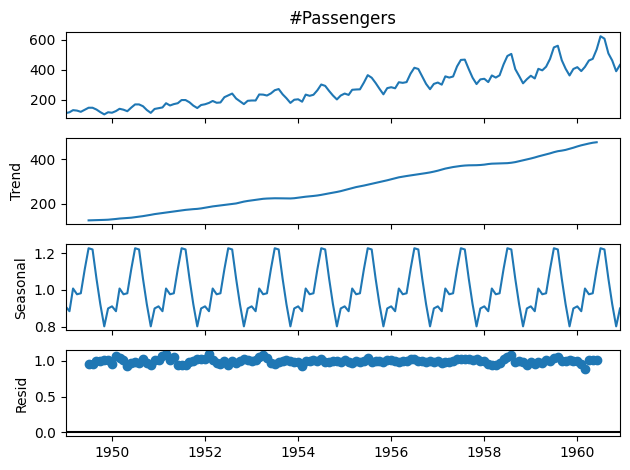

In [15]:
# Multiplicative
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_plot_multi = seasonal_decompose(data2['#Passengers'],
                                              model='multiplicative')
decomposition_plot_multi.plot()
plt.show()

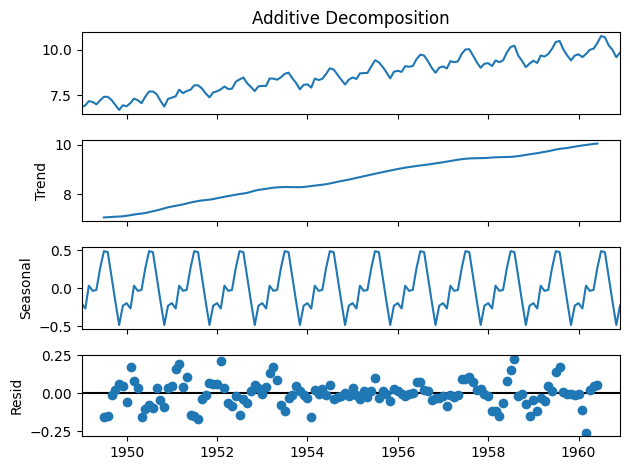

In [16]:
# Additive
# Apply boxcox to acquire additive model
data2['Additive Decomposition'], lam = boxcox(data2['#Passengers'])

# Plot the decomposition for additive series
decomposition_plot_add = seasonal_decompose(data2['Additive Decomposition'],
                                            model='additive')
decomposition_plot_add.plot()
plt.show()

## Autocorrelation

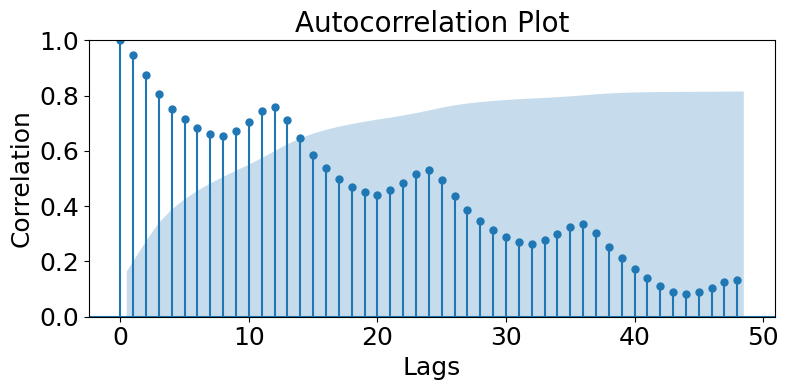

In [17]:
# Plot autocorrelation
from statsmodels.graphics.tsaplots import plot_acf

plt.rc("figure", figsize=(8,4))
plot_acf(data2['#Passengers'], lags=48)
plt.ylim(0,1)
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Autocorrelation Plot', fontsize=20)
plt.tight_layout()
plt.show()

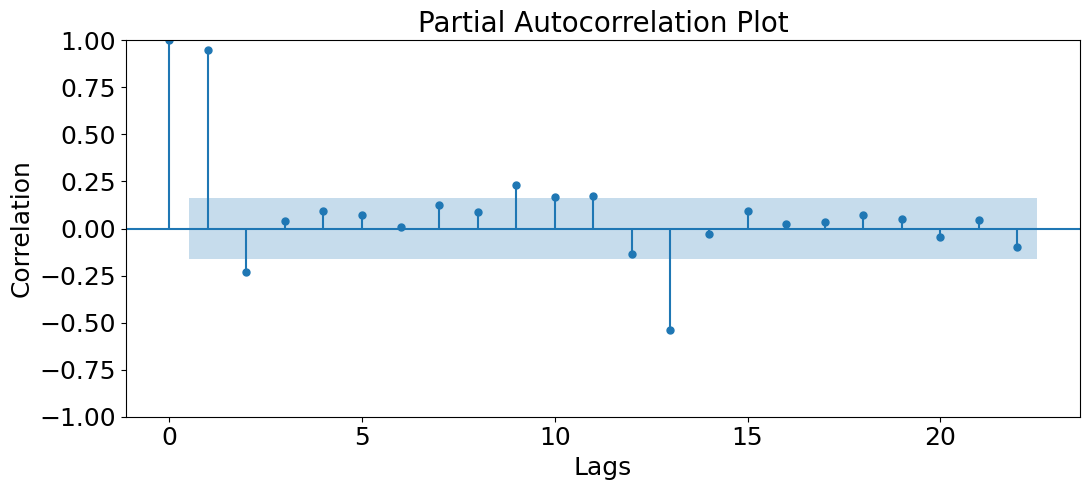

In [18]:
# Plot partial autocorrelation
from statsmodels.graphics.tsaplots import plot_pacf

plt.rc("figure", figsize=(11,5))
plot_pacf(data2['#Passengers'], method='ywm')
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Partial Autocorrelation Plot', fontsize=20)
plt.tight_layout()
plt.show()

# Forecasts Models

## Holt Winters


Two different Holt Winters’ model, additive and multiplicative.

The difference between the two models is the size of the seasonality fluctuations. For an additive model the seasonality fluctuations are mostly constant. However, for multiplicative model the fluctuations are proportional to the value of the time series at that given time.

In [19]:
import plotly.graph_objects as go
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [20]:
# Split train and test
train = data3.iloc[:-int(len(data3) * 0.2)]
test = data3.iloc[-int(len(data3) * 0.2):]

def plot_func(forecasts: list[float],
              title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Month'], y=train['#Passengers'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Month'], y=test['#Passengers'], name='Test'))
    fig.add_trace(go.Scatter(x=test['Month'], y=forecasts, name='Holt Winters'))
    fig.update_layout(template="simple_white", font=dict(size=18),
                      title_text=title, width=700, title_x=0.5, height=400,
                      xaxis_title='Date', yaxis_title='Passenger Volume')
    return fig.show()

# Fit Holt Winters model and get forecasts
model = ExponentialSmoothing(train['#Passengers'], trend='mul',
                             seasonal='mul', seasonal_periods=12,)\
                                          .fit(optimized=True)
forecasts = model.forecast(len(test))

# Plot the forecast
plot_func(forecasts,  "Holt-Winters Exponential Smoothing")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning:

overflow encountered in matmul



In [21]:
print(model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:              #Passengers   No. Observations:                  116
Model:             ExponentialSmoothing   SSE                          10336.958
Optimized:                         True   AIC                            552.827
Trend:                   Multiplicative   BIC                            596.885
Seasonal:                Multiplicative   AICC                           559.879
Seasonal Periods:                    12   Date:                 Thu, 30 Jan 2025
Box-Cox:                          False   Time:                         07:51:54
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3853483                alpha                 True
smoothing_trend          

## Residuals analysis

In [22]:
# Appending residuals and fitted values to the train dataframe
train['fittedvalues'] = model.fittedvalues
train['residuals'] = model.resid
print(train)

         Month  #Passengers  fittedvalues  residuals
0   1949-01-01          112    111.997011   0.002989
1   1949-02-01          118    119.397772  -1.397772
2   1949-03-01          132    132.485694  -0.485694
3   1949-04-01          129    126.790028   2.209972
4   1949-05-01          121    118.553190   2.446810
..         ...          ...           ...        ...
111 1958-04-01          348    370.894734 -22.894734
112 1958-05-01          363    370.984509  -7.984509
113 1958-06-01          435    435.713085  -0.713085
114 1958-07-01          491    479.724073  11.275927
115 1958-08-01          505    479.483081  25.516919

[116 rows x 4 columns]


<ipython-input-22-bff41dd2c1b7>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-22-bff41dd2c1b7>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



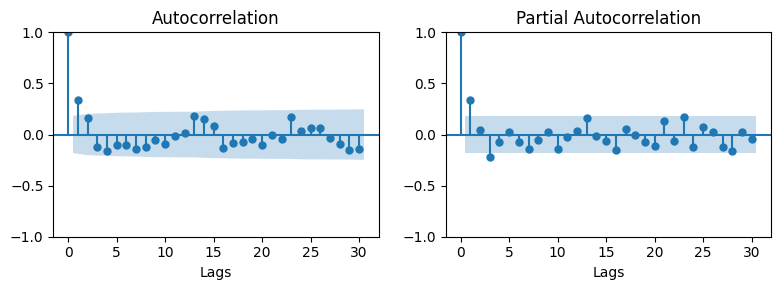

In [23]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Plot ACF and PACF
fig, ax = plt.subplots(1,2,figsize=(8,3))
plot_acf(train['residuals'], lags=30, ax=ax[0])
ax[0].set_xlabel('Lags')
plot_pacf(train['residuals'], lags=30, ax=ax[1])
ax[1].set_xlabel('Lags')
plt.tight_layout()
plt.show()

In [24]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Carry out Ljung-Box test
print(acorr_ljungbox(train['residuals'], return_df=True))

      lb_stat  lb_pvalue
1   13.917146   0.000191
2   16.931975   0.000211
3   18.861072   0.000292
4   22.061208   0.000195
5   23.398389   0.000283
6   24.627916   0.000400
7   27.059270   0.000325
8   29.031125   0.000313
9   29.344194   0.000567
10  30.414797   0.000733


This shows the p-values of the first 10 lags. They are all below the significance level of 0.05, therefore we reject the null hypothesis of no autocorrelation. Thus, there is correlation present in our residuals that we need to revisit when re-fitting the model.

### Compute residuals offset

In [25]:
# Plot histogram of the residuals and compute offset
fig = px.histogram(train, x="residuals")
fig.update_layout(template="simple_white", font=dict(size=18),
                  title_text='Distribution of Residuals',
                  width=700, title_x=0.5, height=400,
                  xaxis_title='Residuals', yaxis_title='Count')
fig.show()

# Mean of residuals
print(train['residuals'].mean())

-0.023048689329401923


In [26]:
# Add a fixed additive offset of 0.02
adjusted_forecasts = model.forecast(len(test)) + 0.02

plot_func(adjusted_forecasts,  "Holt-Winters Exponential Smoothing")

## Errors metrics

In [27]:
"""
- Mean absolute percentage error
- Symmetric Mean absolute percentage error
- Mean squared logarithm error
"""

'\n- Mean absolute percentage error\n- Symmetric Mean absolute percentage error\n- Mean squared logarithm error\n'

In [37]:
# MAPE
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(test["#Passengers"], forecasts)
print(mape)

0.054633523103759664


## Autoregressive Model

In [34]:
from scipy.stats import boxcox

def plot_passenger_volumes(df: pd.DataFrame,
                           y: str) -> None:
    """General function to plot the passenger data."""

    fig = px.line(df, x='Month', y=y, labels={'Month': 'Date'})
    fig.update_layout(template="simple_white", font=dict(size=18), title_text='Airline Passengers',
                      width=650, title_x=0.5, height=400)

    return fig.show()

# Make the target stationary
data3['Passengers_boxcox'], lam = boxcox(data3['#Passengers'])
data3["Passenger_stationary"] = data3["Passengers_boxcox"].diff()
data3.dropna(inplace=True)

# Plot the stationary airline passenger data
plot_passenger_volumes(df=data3, y='Passenger_stationary')

In [35]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# Split train and test
train = data3.iloc[:-int(len(data3) * 0.2)]
test = data3.iloc[-int(len(data3) * 0.2):]

# Build AR model
selector = ar_select_order(train['Passenger_stationary'], 15) # try first 15 lags
model = AutoReg(train['Passenger_stationary'], lags=selector.ar_lags).fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.



In [36]:
from scipy.special import inv_boxcox
import plotly.graph_objects as go

# Get forecasts and convert to actual passenger volumes
transformed_forecasts = list(model.forecast(steps=len(test)))
boxcox_forecasts = []
for idx in range(len(test)):
    if idx == 0:
        boxcox_forecast = transformed_forecasts[idx] + train['Passengers_boxcox'].iloc[-1]
    else:
        boxcox_forecast = transformed_forecasts[idx] + boxcox_forecasts[idx-1]

    boxcox_forecasts.append(boxcox_forecast)

forecasts = inv_boxcox(boxcox_forecasts, lam)


def plot_forecasts(forecasts: list[float],
                   title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Month'], y=train['#Passengers'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Month'], y=test['#Passengers'], name='Test'))
    fig.add_trace(go.Scatter(x=test['Month'], y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')

    return fig.show()

# Plot the forecasts
plot_forecasts(forecasts, 'Autoregression')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [38]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(test["#Passengers"], forecasts)
print(mape)

0.054633523103759664


## Moving Average Model

In [39]:
# Plot the airline passenger data
plot_passenger_volumes(df=data3, y='#Passengers')

In [40]:
# Import packages
from scipy.stats import boxcox

# Make the target stationary
data3['Passengers_boxcox'], lam = boxcox(data3['#Passengers'])
data3["Passenger_stationary"] = data3["Passengers_boxcox"].diff()
data3.dropna(inplace=True)

# Plot the stationary airline passenger data
plot_passenger_volumes(df=data3, y='Passenger_stationary')

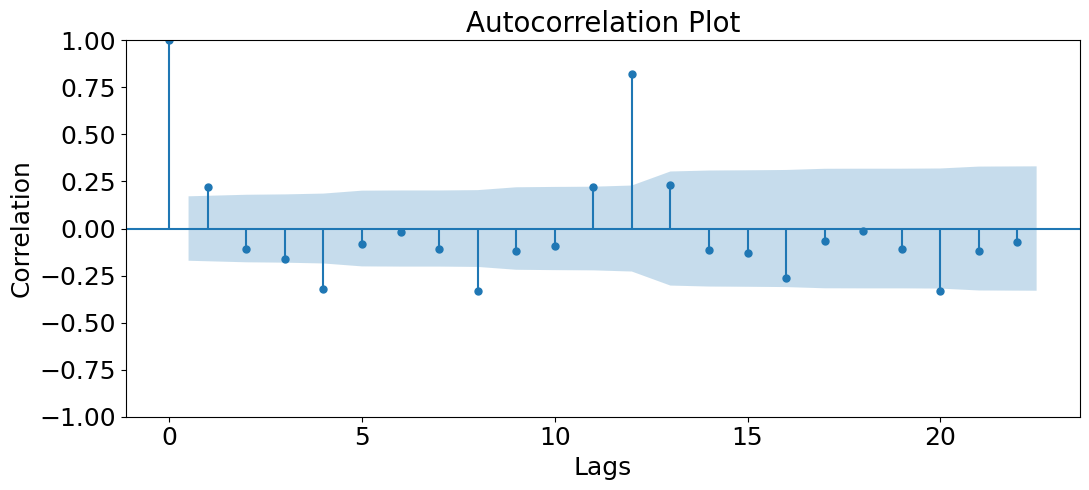

In [44]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot autocorrelation
plt.rc("figure", figsize=(11,5))
plot_acf(data['Passenger_stationary'])
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Autocorrelation Plot', fontsize=20)
plt.tight_layout()
plt.show()

In [45]:
# Import packages
from statsmodels.tsa.arima.model import ARIMA

# Split train and test
train = data3.iloc[:-int(len(data3) * 0.2)]
test = data3.iloc[-int(len(data3) * 0.2):]

# Train model
model = ARIMA(train['Passenger_stationary'], order=(0, 0, 13)).fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:60

In [46]:
# Import packages
from scipy.special import inv_boxcox
import plotly.graph_objects as go

# Get forecasts and convert to actual passenger volumes
transformed_forecasts = list(model.forecast(steps=len(test)))
boxcox_forecasts = []
for idx in range(len(test)):
    if idx == 0:
        boxcox_forecast = transformed_forecasts[idx] + train['Passengers_boxcox'].iloc[-1]
    else:
        boxcox_forecast = transformed_forecasts[idx] + boxcox_forecasts[idx-1]

    boxcox_forecasts.append(boxcox_forecast)

forecasts = inv_boxcox(boxcox_forecasts, lam)


def plot_forecasts(forecasts: list[float],
                   title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Month'], y=train['#Passengers'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Month'], y=test['#Passengers'], name='Test'))
    fig.add_trace(go.Scatter(x=test['Month'], y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')

    return fig.show()


# Plot the forecasts
plot_forecasts(forecasts, 'Moving Average Model')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



## ARIMA

The model is usefully written in a short-hand way as ARIMA(p, d, q) where p, d and q refer to the order of autoregressors, differencing and moving-averages components respectively.

In [48]:
# Import packages
from scipy.stats import boxcox

# Make the target variance stationary
data3['Passengers_Boxcox'], lam = boxcox(data3['#Passengers'])

# Plot the box-cox passenger data
plot_passenger_volumes(df=data3, y='Passengers_Boxcox')

# The stats model package makes the mean stationary, that's why we don't need to apply diff

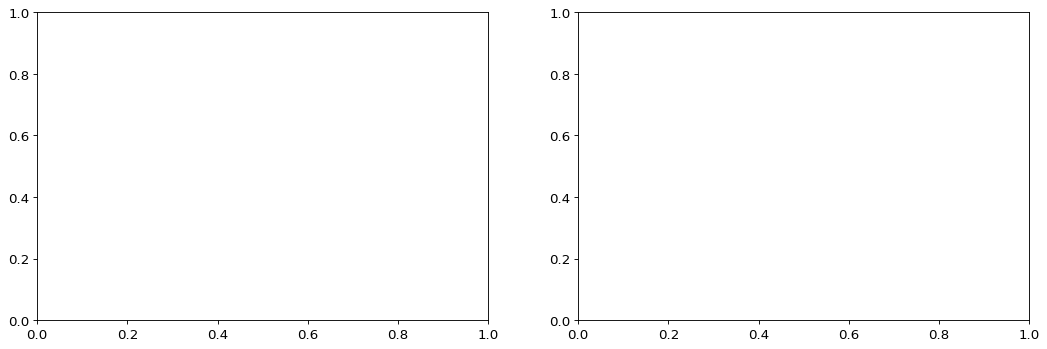

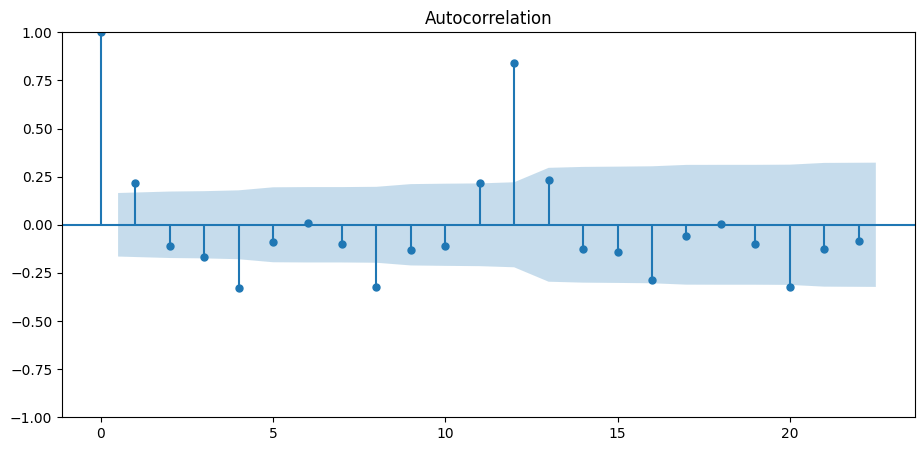

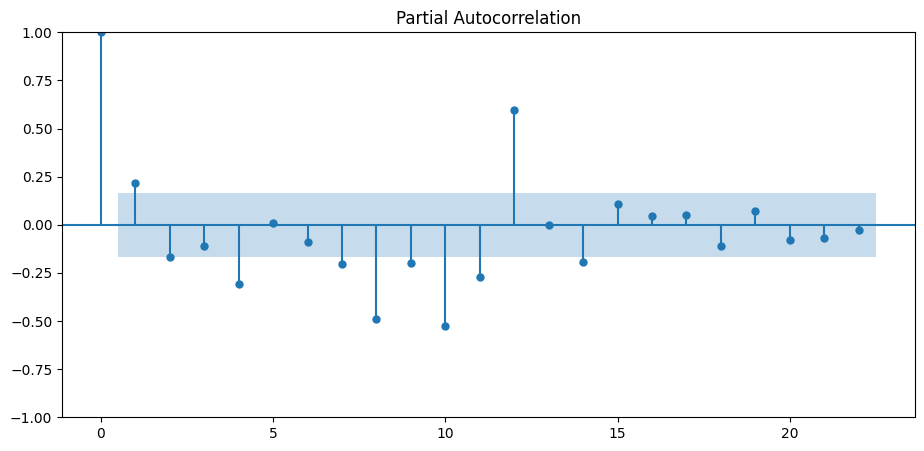

In [50]:
# Import packages
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Difference the data
data3["Passenger_diff"] = data3["Passengers_Boxcox"].diff()
data3.dropna(inplace=True)

# Plot acf and pacf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), dpi=80)
plot_acf(data3['Passenger_diff'])
plot_pacf(data3['Passenger_diff'], method='ywm')
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()

In [52]:
# Import packages
from statsmodels.tsa.arima.model import ARIMA
from scipy.special import inv_boxcox

# Split train and test
train = data3.iloc[:-int(len(data3) * 0.2)]
test = data3.iloc[-int(len(data3) * 0.2):]

# Build ARIMA model and inverse the boxcox
model = ARIMA(train['Passengers_Boxcox'], order=(12, 1, 12)).fit()
boxcox_forecasts = model.forecast(len(test))
forecasts = inv_boxcox(boxcox_forecasts, lam)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/

In [53]:
# Import packages
import plotly.graph_objects as go

def plot_forecasts(forecasts: list[float], title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Month'], y=train['#Passengers'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Month'], y=test['#Passengers'], name='Test'))
    fig.add_trace(go.Scatter(x=test['Month'], y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')

    return fig.show()


# Plot the forecasts
plot_forecasts(forecasts, 'ARIMA')

In [54]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(test["#Passengers"], forecasts)
print(mape)

0.04446942001031891


## ARIMAX with Fourier Series - Dynamic Harmonic Regression

For ARIMA models we can add extra external features to aid in the forecasting. These features are called exogenous features and make the ARIMA model become an ARIMAX model. For example, we may use the current interest rates as an exogenous feature when forecasting the value of a house.

In [55]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.8 MB/s eta 0:00:00


In [57]:
import plotly.graph_objects as go
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import pmdarima as pm

# Read in the data
data4 = pd.read_csv(f'{data_dir}AirPassengers.csv')
data4['Month'] = pd.to_datetime(data4['Month'])
data4['month_num'] = data4['Month'].dt.month

In [61]:
# Stabilise the variance
data4['Passengers_Boxcox'], lam = boxcox(data4['#Passengers'])
data4.dropna(inplace=True)

# Get fourier features
for order in range(1, 10):
    data4[f'fourier_sin_order_{order}'] = np.sin(2 * np.pi * order * data4['month_num'] / 12)
    data4[f'fourier_cos_order_{order}'] = np.cos(2 * np.pi * order * data4['month_num'] / 12)

# name of fourier features
fourier_features = [i for i in list(data4) if i.startswith('fourier')]

print(data4.columns)
data4.head()

Index(['Month', '#Passengers', 'month_num', 'Passengers_Boxcox',
       'fourier_sin_order_1', 'fourier_cos_order_1', 'fourier_sin_order_2',
       'fourier_cos_order_2', 'fourier_sin_order_3', 'fourier_cos_order_3',
       'fourier_sin_order_4', 'fourier_cos_order_4', 'fourier_sin_order_5',
       'fourier_cos_order_5', 'fourier_sin_order_6', 'fourier_cos_order_6',
       'fourier_sin_order_7', 'fourier_cos_order_7', 'fourier_sin_order_8',
       'fourier_cos_order_8', 'fourier_sin_order_9', 'fourier_cos_order_9'],
      dtype='object')


,Month,#Passengers,month_num,Passengers_Boxcox,fourier_sin_order_1,fourier_cos_order_1,fourier_sin_order_2,fourier_cos_order_2,fourier_sin_order_3,fourier_cos_order_3,...,fourier_sin_order_5,fourier_cos_order_5,fourier_sin_order_6,fourier_cos_order_6,fourier_sin_order_7,fourier_cos_order_7,fourier_sin_order_8,fourier_cos_order_8,fourier_sin_order_9,fourier_cos_order_9
0,1949-01-01,112,1,6.827488,0.500000,8.660254e-01,8.660254e-01,0.5,1.000000e+00,6.123234e-17,...,0.500000,-8.660254e-01,1.224647e-16,-1.0,-0.500000,-8.660254e-01,-8.660254e-01,-0.5,-1.000000e+00,-1.836970e-16
1,1949-02-01,118,2,6.932820,0.866025,5.000000e-01,8.660254e-01,-0.5,1.224647e-16,-1.000000e+00,...,-0.866025,5.000000e-01,-2.449294e-16,1.0,0.866025,5.000000e-01,8.660254e-01,-0.5,3.673940e-16,-1.000000e+00
2,1949-03-01,132,3,7.161889,1.000000,6.123234e-17,1.224647e-16,-1.0,-1.000000e+00,-1.836970e-16,...,1.000000,1.194340e-15,3.673940e-16,-1.0,-1.000000,-4.286264e-16,-4.898587e-16,1.0,1.000000e+00,5.510911e-16
3,1949-04-01,129,4,7.114609,0.866025,-5.000000e-01,-8.660254e-01,-0.5,-2.449294e-16,1.000000e+00,...,-0.866025,-5.000000e-01,-4.898587e-16,1.0,0.866025,-5.000000e-01,-8.660254e-01,-0.5,-7.347881e-16,1.000000e+00
4,1949-05-01,121,5,6.983785,0.500000,-8.660254e-01,-8.660254e-01,0.5,1.000000e+00,1.194340e-15,...,0.500000,8.660254e-01,2.388680e-15,-1.0,-0.500000,8.660254e-01,8.660254e-01,-0.5,-1.000000e+00,8.578717e-16


In [67]:
# Display sin and cosine functions
fig = go.Figure()

for col in range(4, len(data4.columns)):
    fig.add_trace(go.Scatter(x=train['Month'], y=data4.iloc[:,col], name=data4.columns[col]))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text="Sin and cosine",
                      width=1300, title_x=0.5, height=800, xaxis_title='Date',
                      yaxis_title='Passenger Volume')

fig.show()

In [68]:
# Split train and test
train = data4.iloc[:-int(len(data4) * 0.2)]
test = data4.iloc[-int(len(data4) * 0.2):]

# Build auto-ARIMA model with fourier features
model = pm.auto_arima(train['Passengers_Boxcox'],
                      X=train[fourier_features],
                      seasonal=False,
                      stepwise=True,
                      suppress_warnings=True,
                      max_order=None,
                      information_criterion='aicc',
                      error_action="ignore")

# Get the forecasts and apply inverse box-cox transform
boxcox_forecasts = model.predict(n_periods=len(test), X=test[fourier_features])
forecasts = inv_boxcox(boxcox_forecasts, lam)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all

In [69]:
def plot_forecasts(forecasts: list[float], title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Month'], y=train['#Passengers'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Month'], y=test['#Passengers'], name='Test'))
    fig.add_trace(go.Scatter(x=test['Month'], y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')

    return fig.show()


# Plot the forecasts
plot_forecasts(forecasts, 'Harmonic Regression')